# 1. Sentiment Analisys

## 1.0 Preparación de datos

El problema de sentiment analysis se puede entender como un problema de clasificación.

### Imports y funciones auxiliares

In [15]:
import numpy as np
import pandas as pd
import io, re
import matplotlib.pyplot as plt
from datetime import datetime
from random import sample

In [16]:
from sklearn.metrics import confusion_matrix

In [1]:
RESULT_FILE='results/resultados_modelos.csv'

In [17]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [18]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()
    metricas = [acc, sen,esp,ppv,fsc]
    return metricas

In [19]:
columns = ['Modelo', 'parametros-optimos', 'train', 'test', 'confusion_matrix', 'acc_sen_esp_ppv_fsc']

resultadosModelo = pd.DataFrame(columns=columns)

def add_row(df, row):
    df.loc[-1] = row
    df.index = df.index + 1  
    return df.sort_index()

In [21]:
%pprint

Pretty printing has been turned ON


### Lectura

Se lee el dataset en un dataframe para su manipulación.

In [165]:
df = pd.read_csv('datasets/train_sentiment_utf8.csv')

In [166]:
df = df.rename(columns={'ï»¿ItemID': "ItemID"})

df.head(10)

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
5,6,0,or i just worry too much?
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,8,0,Sunny Again Work Tomorrow :-| ...
8,9,1,handed in my uniform today . i miss you ...
9,10,1,hmmmm.... i wonder how she my number @-)


### Limpieza

Los entrenamientos de los modelos son importantes, pero se necesita que la información que se alimenta al modelo sea buena, con lo que es necesario antes de plantear cualquier tipo de modelo realizar una buena limpieza de los datos.

Para ello, cargamos el dataset principal en un dataframe y realizamos una limpieza de los datos, eliminando espacios, caracteres especiales y demás.

Sustituyo todos los caracteres especiales de HTML (&amp;amp, &amp;quote...) por caracteres normales.
Tambien tokenizo algunas caracteriticas propias de twits, como menciones, hashtags y urls.

In [167]:
#Algunas filas de prueba para ver que funciona
def sacaSentimentText(lista_ids):
    respuesta = ''
    for e in lista_ids:
        respuesta += df.iloc[e]["SentimentText"] + '\n'
    
    return respuesta

antes = sacaSentimentText([56,126,181,650])

In [168]:
def replace_re (cad, regex, token):
    return re.sub(regex, token, cad)

In [169]:
# quitar espacios antes y despues del texto
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.strip())  

# quitar espacios multiples en la cadena 'The    quick  lazy    fox'->'The quick lazy fox' 
extraSpaces_re = r' +'
df['SentimentText'] = df['SentimentText'].apply(lambda x: replace_re(x, extraSpaces_re, " ")) 

# Cambiar special HTML entities (de http://www.htmlhelp.com/reference/html40/entities/special.html)
#  &amp; 	&lt; 	&gt; &circ; &tilde;
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&amp;', '& '))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&lt;', '<'))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&gt;', '>'))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&circ;', '^'))

# &ensp; &emsp; &thinsp; -> ' '
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&ensp;', ' '))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&thinsp;', ' '))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&emsp;', ' '))

# &ndash; 	&mdash; -> '-'
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&ndash;', '-'))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&mdash;', '-'))

# ' &quot; &lsquo; &rsquo; &sbquo; &ldquo; &rdquo; &bdquo; &lsaquo; &rsaquo;  -> "'"
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('"', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&quot;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&lsquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&rsquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&sbquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&ldquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&rdquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&bdquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&lsaquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&rsaquo;', "'"))
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&quot;', "'"))

# euro sign	&euro;	&#8364;	&#x20AC;	€	€	€
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.replace('&euro;', '€'))

# quitar @username (mentions) y cambiarlo por un token
twitterHandle_re = r'(^|[^@\w])@(\w{1,15})\b'
df['SentimentText'] = df['SentimentText'].apply(lambda x: replace_re(x, twitterHandle_re, "<MENTION>")) 

# hashtag
hashtag_re = r'(?:^|\s|\')[＃#]{1}(\w+)'
df['SentimentText'] = df['SentimentText'].apply(lambda x: replace_re(x, hashtag_re, "<HASHTAG>")) 

# urls
url_re = r'[localhost|http|https|ftp|file]+://[\w\S(\.|:|/)]+'
df['SentimentText'] = df['SentimentText'].apply(lambda x: replace_re(x, url_re, "<URL> ")) 

# quitar espacios antes y despues del texto (los que se hayan podido meter despues de las sustituciones)
df['SentimentText'] = df['SentimentText'].map(lambda SentimentText: SentimentText.strip())  


In [170]:
despues = sacaSentimentText([56,126,181,650])

print('ANTES: \n'+antes+'\n\nDESPUES:\n'+ despues)

ANTES: 
  friends are leaving me 'cause of this stupid love  http://bit.ly/ZoxZC
  Why Twitter will soon become obsolete? http://www.imediaconnection.com/content/23465.asp
 @adbert: &quot;#Video [Woody Woodpecker Ã¢â¬â The Barber of Seville] I am great, @klitoria, just wishing to be a ch... Ã¢â¢Â« http://blip.fm/~7g6r0
 #squaresp #squarespac #squarespace #trackle giveaways giveway iphonegiveway squarespace squarespce trackle


DESPUES:
friends are leaving me 'cause of this stupid love <URL>
Why Twitter will soon become obsolete? <URL>
<MENTION>: <HASHTAG> [Woody Woodpecker Ã¢â¬â The Barber of Seville] I am great,<MENTION>, just wishing to be a ch... Ã¢â¢Â« <URL>
<HASHTAG><HASHTAG><HASHTAG><HASHTAG> giveaways giveway iphonegiveway squarespace squarespce trackle



### Vectorizar el dataframe

El dataframe ahora tiene que ser vectorizado.

In [171]:
df = df.drop(['ItemID'], axis=1)
df.head(10)

,Sentiment,SentimentText
0,0,is so sad for my APL friend.............
1,0,I missed the New Moon trailer...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I've been at ...
4,0,i think mi bf is cheating on me!!! T_T
5,0,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sunny Again Work Tomorrow :-| TV Tonight
8,1,handed in my uniform today . i miss you already
9,1,hmmmm.... i wonder how she my number @-)


In [173]:
df.to_csv('datasets/sentiment_dataset_limpio.csv')

In [17]:
sentiment_dataset = []
for index, row in df.iterrows():
    if index>0:
        label = 'POS' if row[0] == 1 else 'NEG' 
        sentiment_dataset.append((row[1],label))
print(sentiment_dataset[0:5])
len(sentiment_dataset)

[('I missed the New Moon trailer...', 'NEG'), ('omg its already 7:30 :O', 'POS'), (".. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...", 'NEG'), ('i think mi bf is cheating on me!!! T_T', 'NEG'), ('or i just worry too much?', 'NEG')]


99988

## 1.1 Sentiment Analisys con Machine Learning

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [19]:
def split_train_val_test(dataset, split=0.2):

    x, y = zip(*dataset)
    x = np.array(list(x))
    y = np.array(list(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=1337) #l33t seed
    for train_index, test_index in sss.split(x, y):
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
    splits = {'train':(x_train, y_train), 'test':(x_val, y_val)}
    return splits

In [20]:
sample([x for x, y in sentiment_dataset if y=='POS'], 5)


['<MENTION> thank you for the follow',
 "'Everythings Magic!'",
 "<MENTION> you shouldn't be.",
 '<MENTION> i think im amazing too! you know i love you too! and im not jealous of you spitting so suck a dick love <3',
 "<MENTION> *flys to Scotland, goes to lowri's house, kills fly*"]

In [21]:
split = split_train_val_test(sentiment_dataset, 0.3)

### 1.1.1 Bayes

In [16]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()), #MultinomialNB
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'clf__alpha', 'clf__class_prior', 'clf__fit_prior'])

In [17]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb')
    }

In [18]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=7, verbose=1, cv=3)

In [19]:
grid_search.fit(split['train'][0], split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   58.1s
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=7)]: Done 108 out of 108 | elapsed:  4.5min finished


	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
Best score: 0.761


In [20]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(split['test'][0], split['test'][1])
print('TEST SCORE: {}'.format(predictions))

TEST SCORE: 0.7715438210487715


In [24]:
predictions = pipeline.predict(split['test'][0])

In [25]:
confmat = confusion_matrix(split['test'][1], predictions)

In [23]:
split['test'][1]

array(['NEG', 'POS', 'POS', ..., 'POS', 'POS', 'NEG'], dtype='<U3')

In [26]:
confmat

array([[ 9144,  3916],
       [ 2937, 14000]])

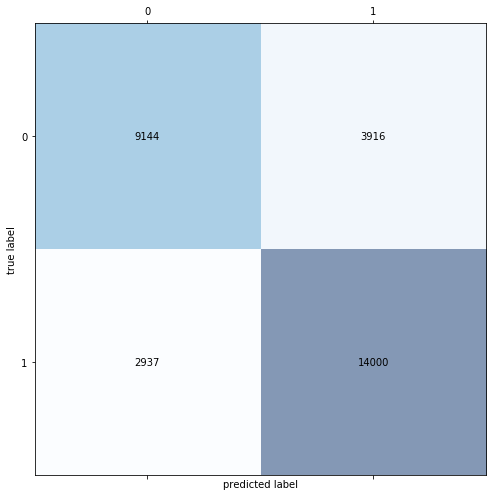

ACC:  0.7715438210487715
SEN:  0.8265926669421976
ESP:  0.7001531393568147
PPV:  0.7814244250948873
FSC:  0.8033741715203856


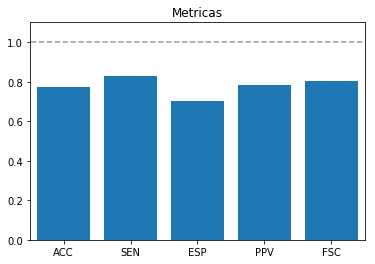

[0.7715438210487715, 0.8265926669421976, 0.7001531393568147, 0.7814244250948873, 0.8033741715203856]

In [30]:
plot_confusion_matrix(confmat)
calcula_metricas(confmat)

### 1.1.2 SVM

En la implementación de SVMs, el elegir de forma correcta los parametros de la misma (C y gamma) es bastante critico. Al ser el cáculo de estos parametros muy intenso, voy a usar un metodo de aproximaciones sucesivas, para centrar cual es la región de los parametros que dá mejor resultado, fijar los parámetros del vectorizador, y intentar afinar C y Gamma para esos parametros.

In [22]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svm', SVC()), #SVC
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'svm', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'svm__C', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [42]:
vetorC = vectorC = np.logspace(-9, 0, 5)
vectorG = np.logspace(-3, 3, 5)

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'svm__C': vectorC, 
    'svm__gamma':vectorG
    }

In [43]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [45]:
hora_inicio = datetime.now()

print("He empezado a las: ",hora_inicio)

grid_search.fit(split['train'][0], split['train'][1])

hora_fin = datetime.now()

tiempo_train = hora_fin - hora_inicio

print("He terminado a las: ",hora_fin)
print("Me ha costado: ", tiempo_train)

best_parameters = grid_search.best_estimator_.get_params()

He empezado a las:  2019-09-18 19:58:51.236947
Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 91.3min
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 1187.3min


KeyboardInterrupt: 

![](https://media.giphy.com/media/rftarkt7Ki2Gs/200w_d.gif)

Después de usar un **día** en realizar un primer intento de cálculo con los 99989 datos y los parámetros elegidos, me he dado cuenta que al ritmo que iba, tardaría 96 horas en realizar el GridSearch. Como no es una opción, y el objetivo no es sacar un modelo certero sino mostrar la metodología, voy a generar un dataset nuevo y más pequeño (10000 datos) y repito el estudio con menos parámetros.

Quiero usar un dataset proporcional al que tengo originalmente, con lo que saco la cantidad de registros que hay de cada uno de los sentimientos y sampleo en proporción.

In [23]:
df.groupby('Sentiment').agg(['count']).stack()

,,SentimentText
Sentiment,,
0,count,43532
1,count,56457


In [24]:
#cojo un 10% de los valores
dfNeg = df[df.Sentiment == 0].sample(4353, random_state=42)
dfPos = df[df.Sentiment == 1].sample(5647, random_state=42)

#concateno los dataframes
frames = [dfNeg, dfPos]
smallDf = pd.concat(frames)

#lo barajeo para que los positivos no esten todos juntos
smallDf = smallDf.sample(frac=1)

In [25]:
#lo guardo para poder usar el dataset en el futuro sin tener que volver a sacarlo
smallDf.to_csv('datasets/train_sentiment_small.csv')

In [26]:
small_sentiment_dataset = []
for index, row in smallDf.iterrows():
    if index>0:
        label = 'POS' if row[0] == 1 else 'NEG' 
        small_sentiment_dataset.append((row[1],label))
print(small_sentiment_dataset[0:5])
len(small_sentiment_dataset)

[('<MENTION> lol ok thanks. anyway watcha doing?', 'POS'), ('<MENTION> -- yeah, thank ya kindly!', 'POS'), ('<MENTION>, is being a horrible friend. tears.', 'NEG'), ("Jonas Brothers 3D Concert Movie is out on the 7th of May and i can't go because of school interviews. BUT i'LL see it sat!!(Hopefully)", 'NEG'), ('<MENTION> k just call asap', 'POS')]


10000

In [27]:
small_split = split_train_val_test(small_sentiment_dataset, 0.3)

In [28]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svm', SVC()), #SVC
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'svm', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'svm__C', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])

In [29]:
vetorC = vectorC = np.logspace(-9, 0, 5)
vectorG = np.logspace(-3, 3, 5)

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'svm__C': vectorC, 
    'svm__gamma':vectorG
    }

In [30]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [163]:
hora_inicio = datetime.now()

print("He empezado a las: ",hora_inicio)

grid_search.fit(small_split['train'][0], small_split['train'][1])

hora_fin = datetime.now()

tiempo_train = hora_fin - hora_inicio

print("He terminado a las: ",hora_fin)
print("Me ha costado: ", tiempo_train)

best_parameters = grid_search.best_estimator_.get_params()

He empezado a las:  2019-09-19 20:03:32.704503
Fitting 3 folds for each of 675 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 77.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 117.0min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 135.0min finished


He terminado a las:  2019-09-19 22:18:40.317531
Me ha costado:  2:15:07.613028


In [167]:
print("best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("best parameters: {}".format(grid_search.best_params_))

best mean cross-validation score: 0.704
best parameters: {'svm__C': 1.0, 'svm__gamma': 0.03162277660168379, 'vect__analyzer': 'word', 'vect__max_df': 1.0, 'vect__ngram_range': (1, 2)}


Fijamos los parametros del vectorizador y hago varias iteraciones con distintos valores de  C y Gamma. No muestro todos los pasos, realizados, sino simplemente el resultado final por no agrandar innecesariamente el notebook.

Primero he usado sólo tres folds y un espacio de C de -5 a 5 y de gamma de -3 a 0 y según como iba evolucionando la gráfica he ido acotando más el rango tanto de C como de gamma. Cuando he logrado acotar el rango de estos valores ha lanzado un entrenamiento con más valores de test de C y G, entrenando con 5 folds (para estar más seguro de la respuesta)

**Iteraciones con C**

```vectorC = np.logspace(-5, 5, 5)```

```vectorC = np.logspace(-4, 3, 5)```

```vectorC = np.logspace(-2, 3, 5)```

```vectorC = np.logspace(-2, 3, 10)```


**Iteraciones con G**

```vectorG = np.logspace(-3, 3, 5)```

```vectorG = np.logspace(-3, 0, 5)```

```vectorG = np.logspace(-3, -0.75, 5)```

```vectorG = np.logspace(-3, -0.75, 10)```


In [31]:
#Fijamos los parametros del Vectorizador
vectorC = np.logspace(-2, 3, 10)
vectorG = np.logspace(-3, -0.75, 10)

parameters = {
    'vect__max_df': ([1.0]),
    'vect__ngram_range': ([(1, 2)]),  #ngrams to test
    'vect__analyzer': (['word']),
    'vect__stop_words': (['english',None]),
    'svm__C': vectorC, 
    'svm__gamma':vectorG
    }

In [32]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [33]:
hora_inicio = datetime.now()

print("He empezado a las: ",hora_inicio)

grid_search.fit(small_split['train'][0], small_split['train'][1])

hora_fin = datetime.now()

tiempo_train = hora_fin - hora_inicio

print("He terminado a las: ",hora_fin)
print("Me ha costado: ", tiempo_train)

best_parameters = grid_search.best_estimator_.get_params()

He empezado a las:  2019-09-20 21:31:03.487932
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 10.1min finished


He terminado a las:  2019-09-20 21:41:15.313026
Me ha costado:  0:10:11.825094


In [34]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

	svm__C: 5.994842503189409
	svm__gamma: 0.01
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__stop_words: None
Best score: 0.716


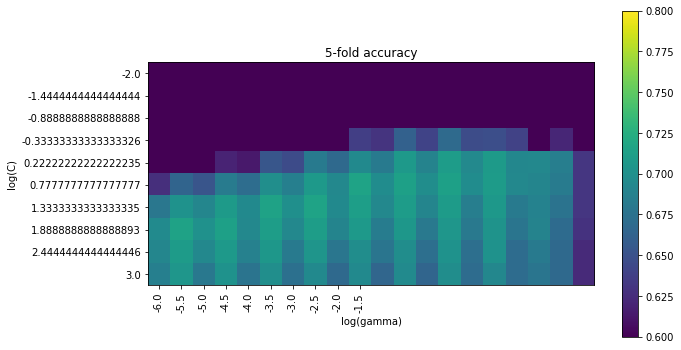

In [35]:
# Mostramos prestaciones en CV
scores = grid_search.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG)*2)

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin= 0.6, vmax=0.8)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG)*2, rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('3-fold accuracy')
plt.show()

Finalmente elegimos los parametros de entrenamiento y comprobamos en test.
Con estos valores obtenemos la matriz de confusión y almacenamos los resultados en un dataframe para facilitar la comparación entre modelos más tarde.

In [36]:
train_score = grid_search.best_score_

In [37]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.733


In [38]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

In [39]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)

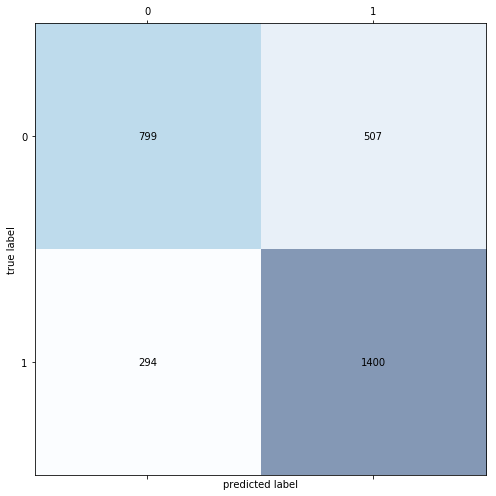

ACC:  0.733
SEN:  0.8264462809917356
ESP:  0.611791730474732
PPV:  0.7341373885684321
FSC:  0.7775617883921133


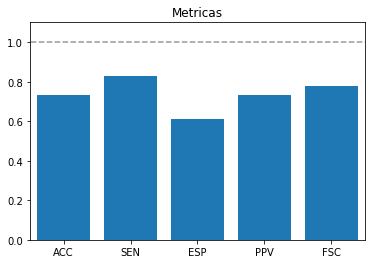

In [40]:
plot_confusion_matrix(confmat)
metricas = calcula_metricas(confmat)

In [41]:
resultado = ['SVM - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716,0.733,"[[799, 507], [294, 1400]]","[0.733, 0.8264462809917356, 0.611791730474732,..."


### 1.1.1b Bayes Reloaded

Como en el entrenamiento con SVM he decidido disminuir el dataset, para poder realizar una comparación homogenea entre distintos algoritmos, es necesario que vuelva a entrenar el modelo de Bayes, pero esta vez con el dataset pequeño.

In [42]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()), #MultinomialNB
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'clf__alpha', 'clf__class_prior', 'clf__fit_prior'])

In [43]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None])
    }

In [44]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [46]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   49.3s finished


	vect__analyzer: 'char'
	vect__max_df: 1.0
	vect__ngram_range: (1, 4)
	vect__stop_words: 'english'
Best score: 0.717


In [47]:
train_score = grid_search.best_score_

In [48]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.7223333333333334


In [49]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

In [50]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)

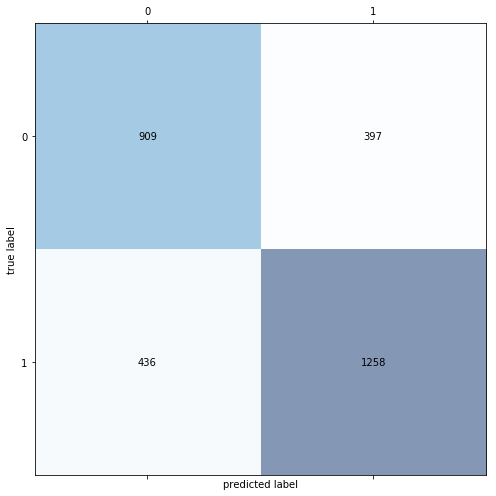

ACC:  0.7223333333333334
SEN:  0.7426210153482881
ESP:  0.6960183767228177
PPV:  0.7601208459214501
FSC:  0.751269035532995


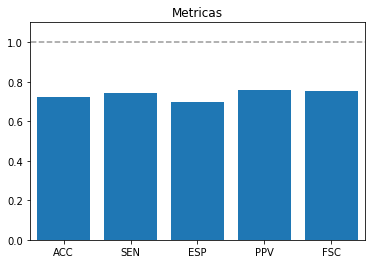

In [51]:
plot_confusion_matrix(confmat)
metricas = calcula_metricas(confmat)

In [52]:
resultado = ['Bayes - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717,0.722333,"[[909, 397], [436, 1258]]","[0.7223333333333334, 0.7426210153482881, 0.696..."
1,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716,0.733000,"[[799, 507], [294, 1400]]","[0.733, 0.8264462809917356, 0.611791730474732,..."


### 1.1.3 Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [56]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tree', DecisionTreeClassifier()), #Decission Tree
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'tree', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tree__class_weight', 'tree__criterion', 'tree__max_depth', 'tree__max_features', 'tree__max_leaf_nodes', 'tree__min_impurity_decrease', 'tree__min_impurity_split', 'tree__min_samples_leaf', 'tree__min_samples_split', 'tree__min_weight_fraction_leaf', 'tree__presort', 'tree__random_state', 'tree__splitter'])

In [57]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None]),
    'tree__max_depth': range(1,20)
    }

In [58]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [59]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 1368 candidates, totalling 4104 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 4104 out of 4104 | elapsed: 19.2min finished


	tree__max_depth: 19
	vect__analyzer: 'word'
	vect__max_df: 1.0
	vect__ngram_range: (1, 4)
	vect__stop_words: 'english'
Best score: 0.653


In [60]:
train_score = grid_search.best_score_

In [61]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.6496666666666666


In [62]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

In [63]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)

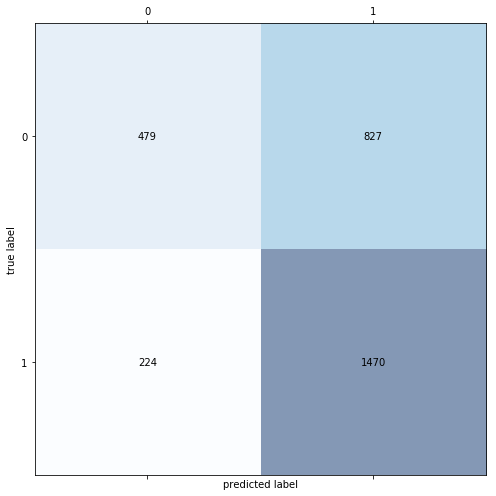

ACC:  0.6496666666666666
SEN:  0.8677685950413223
ESP:  0.3667687595712098
PPV:  0.6399651719634306
FSC:  0.736657479328489


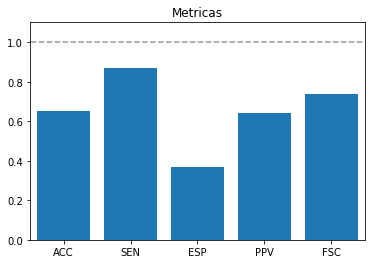

In [64]:
plot_confusion_matrix(confmat)
metricas = calcula_metricas(confmat)

In [65]:
resultado = ['Decision Tree - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,"[[479, 827], [224, 1470]]","[0.6496666666666666, 0.8677685950413223, 0.366..."
1,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,"[[909, 397], [436, 1258]]","[0.7223333333333334, 0.7426210153482881, 0.696..."
2,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,"[[799, 507], [294, 1400]]","[0.733, 0.8264462809917356, 0.611791730474732,..."


### 1.1.4 Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('forest', RandomForestClassifier()), #Random Forest
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'forest', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'forest__bootstrap', 'forest__class_weight', 'forest__criterion', 'forest__max_depth', 'forest__max_features', 'forest__max_leaf_nodes', 'forest__min_impurity_decrease', 'forest__min_impurity_split', 'forest__min_samples_leaf', 'forest__min_samples_split', 'forest__min_weight_fraction_leaf', 'forest__n_estimators', 'forest__n_jobs', 'forest__oob_score', 'forest__random_state', 'forest__verbose', 'forest__warm_start'])

In [71]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None]),
    'forest__max_depth': range(1,30)
    }

In [72]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [73]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 2088 candidates, totalling 6264 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 6264 out of 6264 | elapsed: 24.2min finished
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100

	forest__max_depth: 23
	vect__analyzer: 'char_wb'
	vect__max_df: 1.0
	vect__ngram_range: (1, 4)
	vect__stop_words: 'english'
Best score: 0.669


In [74]:
train_score = grid_search.best_score_

In [75]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.665


In [76]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

In [77]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)

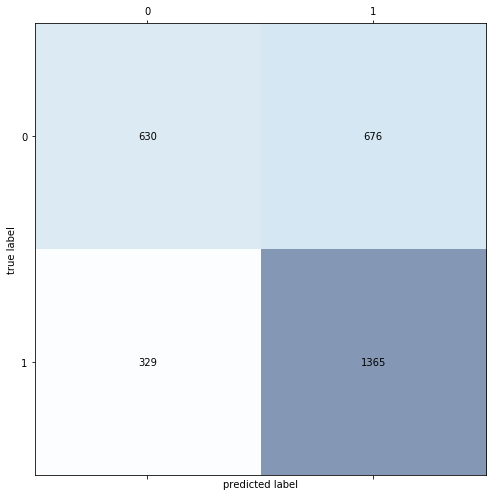

ACC:  0.665
SEN:  0.8057851239669421
ESP:  0.48238897396630936
PPV:  0.6687898089171974
FSC:  0.7309236947791165


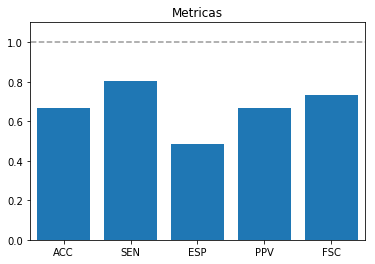

In [78]:
plot_confusion_matrix(confmat)
metricas = calcula_metricas(confmat)

In [79]:
resultado = ['Random Forestyes - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,"[[630, 676], [329, 1365]]","[0.665, 0.8057851239669421, 0.4823889739663093..."
1,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,"[[479, 827], [224, 1470]]","[0.6496666666666666, 0.8677685950413223, 0.366..."
2,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,"[[909, 397], [436, 1258]]","[0.7223333333333334, 0.7426210153482881, 0.696..."
3,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,"[[799, 507], [294, 1400]]","[0.733, 0.8264462809917356, 0.611791730474732,..."


In [80]:
resultadosModelo.to_csv(RESULT_FILE)

### 1.4 Boosted Tree

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25,100,300]
learningRate = [0.1,0.05,0.01]
max_depth_tried = [5,7,9]

In [82]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('boosted', GradientBoostingClassifier()), #Gradient Boosting
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'boosted', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'boosted__criterion', 'boosted__init', 'boosted__learning_rate', 'boosted__loss', 'boosted__max_depth', 'boosted__max_features', 'boosted__max_leaf_nodes', 'boosted__min_impurity_decrease', 'boosted__min_impurity_split', 'boosted__min_samples_leaf', 'boosted__min_samples_split', 'boosted__min_weight_fraction_leaf', 'boosted__n_estimators', 'boosted__n_iter_no_change', 'boosted__presort', 'boosted__random_state', 'boosted__subsample', 'boosted__tol', 'boosted__validation_fraction', 'boosted__verbose', 'boosted__warm_start'])

In [83]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None]),
    'boosted__n_estimators': Niterations,
    'boosted__learning_rate': learningRate,
    'boosted__max_depth': max_depth_tried,
    }

In [84]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [85]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 56.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 91.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 132.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 181.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 252.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 301.9min
[Parallel(n_jobs=-1)]: Done 5832 out of 5832 | elapsed: 424.4min finished


	boosted__learning_rate: 0.1
	boosted__max_depth: 7
	boosted__n_estimators: 300
	vect__analyzer: 'char_wb'
	vect__max_df: 0.5
	vect__ngram_range: (1, 4)
	vect__stop_words: None
Best score: 0.715


In [86]:
train_score = grid_search.best_score_

In [87]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.7286666666666667


In [88]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

In [89]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)

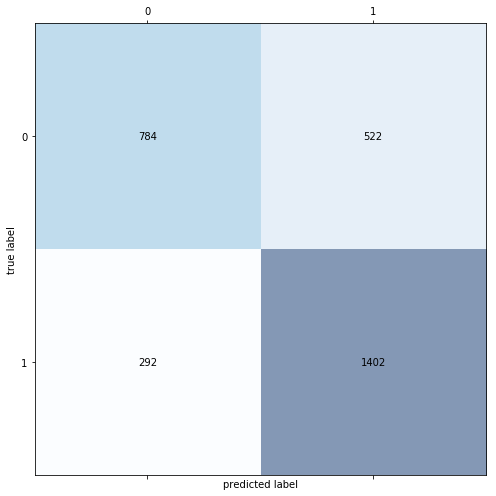

ACC:  0.7286666666666667
SEN:  0.8276269185360094
ESP:  0.6003062787136294
PPV:  0.7286902286902287
FSC:  0.7750138197899391


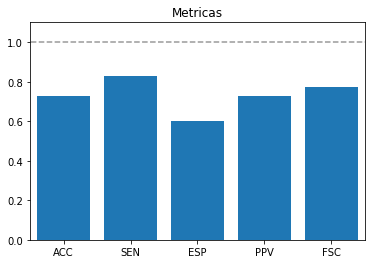

In [90]:
plot_confusion_matrix(confmat)
metricas = calcula_metricas(confmat)

In [91]:
resultado = ['Boosted Tree - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,"[[784, 522], [292, 1402]]","[0.7286666666666667, 0.8276269185360094, 0.600..."
1,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,"[[630, 676], [329, 1365]]","[0.665, 0.8057851239669421, 0.4823889739663093..."
2,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,"[[479, 827], [224, 1470]]","[0.6496666666666666, 0.8677685950413223, 0.366..."
3,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,"[[909, 397], [436, 1258]]","[0.7223333333333334, 0.7426210153482881, 0.696..."
4,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,"[[799, 507], [294, 1400]]","[0.733, 0.8264462809917356, 0.611791730474732,..."


In [92]:
resultadosModelo.to_csv(RESULT_FILE)

### 1.1.5 Mejoras posibles

El análisis de sentimientos se ha hecho con varios modelos distintos obteniendo resultados similares, siendo el mejor el modelo más sencillo, lo que me hace pensar que si hay mejoras que se pueden obtener pasan por mejorar los datos de entrada.

Así pues, voy a aplicar algo de stemming y probar de nuevo con los modelos anteriores, usando la misma algún modelo.


In [64]:
# coger el dataset pequeño
stem_df = pd.read_csv('datasets/train_sentiment_small.csv')
stem_df.head()

,Unnamed: 0,Sentiment,SentimentText
0,33872,1,<MENTION> lol ok thanks. anyway watcha doing?
1,22259,1,"<MENTION> -- yeah, thank ya kindly!"
2,72135,0,"<MENTION>, is being a horrible friend. tears."
3,2448,0,Jonas Brothers 3D Concert Movie is out on the ...
4,85082,1,<MENTION> k just call asap


In [65]:
stem_df = stem_df.drop(['Unnamed: 0'], axis=1)

In [3]:
!pip3 install stop_words

In [4]:
!pip3 install spacy

In [5]:
!python3 -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [7]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
sys.path.append('/Users/unaiherran1/.pyenv/versions/3.7.3/lib/python3.7/site-packages')

In [8]:
import spacy
from stop_words import get_stop_words
from string import punctuation

In [ ]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz --no-deps

     |█████████████████▍              | 20.3MB 1.7MB/s eta 0:00:10

In [78]:
# lematizar
customize_stop_words = get_stop_words('en') + list(punctuation) + [' ', '<URL>', '<MENTION>', '<HASHTAG>',
                                                                  'MENTION', 'URL', 'HASHTAG']

In [11]:
!python3 -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [67]:
nlp = spacy.load('en_core_web_sm')

In [79]:
# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [80]:
stem_df['SentimentLema'] = stem_df.SentimentText.apply(lambda text: 
                                          " ".join(token.lemma_ for token in nlp(text,disable=['parser', 'tagger', 'ner']) if not token.is_stop))

In [82]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')

In [84]:
stem_df['SentimentStem'] = stem_df['SentimentLema'].map(lambda SentimentLema: stemmer.stem(SentimentLema))

In [87]:
# guardarlo lematizado
stem_df.to_csv('datasets/sentiment_text_lemma_stem.csv')
stem_df.head()

,Sentiment,SentimentText,SentimentLema,SentimentStem
0,1,<MENTION> lol ok thanks. anyway watcha doing?,lol okay thank watcha,lol okay thank watcha
1,1,"<MENTION> -- yeah, thank ya kindly!",-- yes thank you kindly,-- yes thank you kind
2,0,"<MENTION>, is being a horrible friend. tears.",horrible friend tear,horrible friend tear
3,0,Jonas Brothers 3D Concert Movie is out on the ...,Jonas Brothers 3D Concert Movie 7th school int...,jonas brothers 3d concert movie 7th school int...
4,1,<MENTION> k just call asap,k asap,k asap


In [91]:
# repetir analisis anterior

# vectorizar

sentiment_dataset = []
for index, row in stem_df.iterrows():
    if index>0:
        label = 'POS' if row[0] == 1 else 'NEG' 
        sentiment_dataset.append((row[3],label))
print(sentiment_dataset[0:5])
len(sentiment_dataset)

[('-- yes thank you kind', 'POS'), ('horrible friend tear', 'NEG'), ("jonas brothers 3d concert movie 7th school interview i'll sat!!(hop", 'NEG'), ('k asap', 'POS'), ('hello mr ryan ross', 'POS')]


9999

In [92]:

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [93]:
# split
def split_train_val_test(dataset, split=0.2):

    x, y = zip(*dataset)
    x = np.array(list(x))
    y = np.array(list(y))
    sss = StratifiedShuffleSplit(n_splits=1, test_size=split, random_state=1337) #l33t seed
    for train_index, test_index in sss.split(x, y):
        x_train, x_val = x[train_index], x[test_index]
        y_train, y_val = y[train_index], y[test_index]
    splits = {'train':(x_train, y_train), 'test':(x_val, y_val)}
    return splits

In [95]:
small_split = split_train_val_test(sentiment_dataset, 0.3)

In [98]:
resultadosModelo = pd.read_csv(RESULT_FILE)
resultadosModelo = resultadosModelo.drop(['Unnamed: 0'], axis=1)

In [99]:
resultadosModelo

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
1,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
2,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
3,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
4,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."


In [101]:
# Bayes
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()), #MultinomialNB
])

In [102]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None])
    }

In [103]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [104]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   26.7s finished


	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__ngram_range: (1, 4)
	vect__stop_words: None
Best score: 0.687


In [105]:
train_score = grid_search.best_score_

In [106]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.6903333333333334


ACC:  0.6903333333333334
SEN:  0.806965761511216
ESP:  0.5390505359877489
PPV:  0.6942610462163534
FSC:  0.7463827463827463


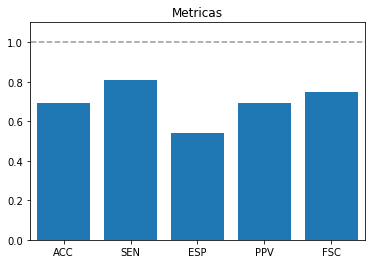

In [107]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)
metricas = calcula_metricas(confmat)


In [108]:
resultado = ['Bayes - Lemma - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,"[[704, 602], [327, 1367]]","[0.6903333333333334, 0.806965761511216, 0.5390..."
1,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
2,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
3,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
4,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
5,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."


In [ ]:
# svm

In [142]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('svm', SVC()), #SVC
])

In [143]:
vetorC = vectorC = np.logspace(-9, 0, 5)
vectorG = np.logspace(-3, 3, 5)

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'svm__C': vectorC, 
    'svm__gamma':vectorG
    }

In [144]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [145]:
hora_inicio = datetime.now()

print("He empezado a las: ",hora_inicio)

grid_search.fit(small_split['train'][0], small_split['train'][1])

hora_fin = datetime.now()

tiempo_train = hora_fin - hora_inicio

print("He terminado a las: ",hora_fin)
print("Me ha costado: ", tiempo_train)

best_parameters = grid_search.best_estimator_.get_params()

He empezado a las:  2019-09-21 18:34:38.994193
Fitting 3 folds for each of 675 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 72.7min finished


He terminado a las:  2019-09-21 19:47:26.167085
Me ha costado:  1:12:47.172892


In [146]:
print("best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("best parameters: {}".format(grid_search.best_params_))

best mean cross-validation score: 0.666
best parameters: {'svm__C': 1.0, 'svm__gamma': 0.03162277660168379, 'vect__analyzer': 'word', 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}


In [149]:
best_parameters = grid_search.best_estimator_.get_params()

In [150]:
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

	svm__C: 1.0
	svm__gamma: 0.03162277660168379
	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
Best score: 0.666


In [151]:
train_score = grid_search.best_score_

In [152]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.685


In [153]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

ACC:  0.685
SEN:  0.9132231404958677
ESP:  0.3889739663093415
PPV:  0.6597014925373135
FSC:  0.7660311958405546


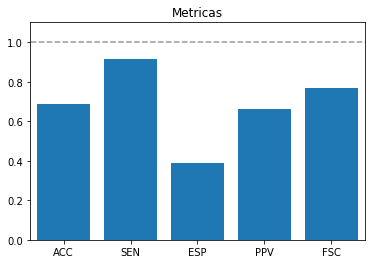

In [154]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)
metricas = calcula_metricas(confmat)

In [155]:
resultado = ['SVM - Lemma - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,SVM - Lemma - Small Dataset,"{'svm__C': 1.0, 'svm__gamma': 0.03162277660168...",0.665524,0.685000,"[[508, 798], [147, 1547]]","[0.685, 0.9132231404958677, 0.3889739663093415..."
1,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,"[[692, 614], [282, 1412]]","[0.7013333333333334, 0.833530106257379, 0.5298..."
2,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,"[[562, 744], [262, 1432]]","[0.6646666666666666, 0.8453364817001181, 0.430..."
3,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,"[[362, 944], [114, 1580]]","[0.6473333333333333, 0.9327036599763873, 0.277..."
4,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,"[[704, 602], [327, 1367]]","[0.6903333333333334, 0.806965761511216, 0.5390..."
5,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
6,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
7,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
8,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
9,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."


In [ ]:
# Decision Tree

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [110]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tree', DecisionTreeClassifier()), #Decission Tree
])

In [111]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None]),
    'tree__max_depth': range(1,20)
    }

In [112]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [113]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 1368 candidates, totalling 4104 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 4104 out of 4104 | elapsed: 10.0min finished


	tree__max_depth: 19
	vect__analyzer: 'word'
	vect__max_df: 0.5
	vect__ngram_range: (1, 3)
	vect__stop_words: None
Best score: 0.650


In [114]:
train_score = grid_search.best_score_

In [115]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.6473333333333333


In [116]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

ACC:  0.6473333333333333
SEN:  0.9327036599763873
ESP:  0.2771822358346095
PPV:  0.6259904912836767
FSC:  0.7491702228544334


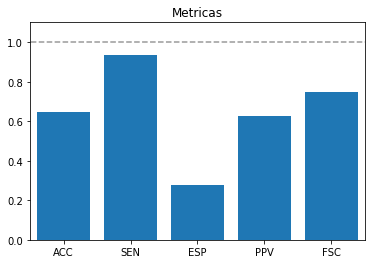

In [117]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)
metricas = calcula_metricas(confmat)

In [118]:
resultado = ['Decision Tree - Lemma - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,"[[362, 944], [114, 1580]]","[0.6473333333333333, 0.9327036599763873, 0.277..."
1,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,"[[704, 602], [327, 1367]]","[0.6903333333333334, 0.806965761511216, 0.5390..."
2,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
3,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
4,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
5,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
6,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."


In [ ]:
# random forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('forest', RandomForestClassifier()), #Random Forest
])

In [121]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None]),
    'forest__max_depth': range(1,30)
    }

In [122]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [123]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 2088 candidates, totalling 6264 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 6264 out of 6264 | elapsed: 13.5min finished


	forest__max_depth: 28
	vect__analyzer: 'char_wb'
	vect__max_df: 0.5
	vect__ngram_range: (1, 4)
	vect__stop_words: None
Best score: 0.660


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [124]:
train_score = grid_search.best_score_

In [125]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.6646666666666666


In [126]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

In [127]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)

ACC:  0.6646666666666666
SEN:  0.8453364817001181
ESP:  0.43032159264931086
PPV:  0.6580882352941176
FSC:  0.7400516795865633


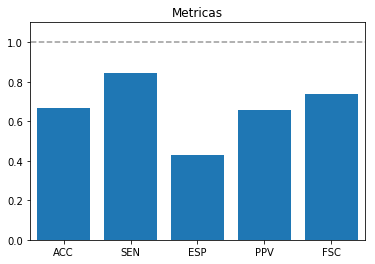

In [128]:
metricas = calcula_metricas(confmat)

In [129]:
resultado = ['Random Forestyes - Lemma - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,"[[562, 744], [262, 1432]]","[0.6646666666666666, 0.8453364817001181, 0.430..."
1,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,"[[362, 944], [114, 1580]]","[0.6473333333333333, 0.9327036599763873, 0.277..."
2,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,"[[704, 602], [327, 1367]]","[0.6903333333333334, 0.806965761511216, 0.5390..."
3,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
4,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
5,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
6,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
7,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."


In [130]:
resultadosModelo.to_csv(RESULT_FILE)
                       

In [ ]:
# boosted tree

In [131]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [30, 300]
learningRate = [0.1, 0.01]
max_depth_tried = [7, 9]

In [132]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('boosted', GradientBoostingClassifier()), #Gradient Boosting
])
pipeline.get_params().keys() # que parametros podemos tocar en el gridsearch!

dict_keys(['memory', 'steps', 'vect', 'boosted', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'boosted__criterion', 'boosted__init', 'boosted__learning_rate', 'boosted__loss', 'boosted__max_depth', 'boosted__max_features', 'boosted__max_leaf_nodes', 'boosted__min_impurity_decrease', 'boosted__min_impurity_split', 'boosted__min_samples_leaf', 'boosted__min_samples_split', 'boosted__min_weight_fraction_leaf', 'boosted__n_estimators', 'boosted__n_iter_no_change', 'boosted__presort', 'boosted__random_state', 'boosted__subsample', 'boosted__tol', 'boosted__validation_fraction', 'boosted__verbose', 'boosted__warm_start'])

In [133]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 2), (1, 3), (2, 3), (1,4)),  #ngrams to test
    'vect__analyzer': ('word', 'char', 'char_wb'),
    'vect__stop_words': (['english',None]),
    'boosted__n_estimators': Niterations,
    'boosted__learning_rate': learningRate,
    'boosted__max_depth': max_depth_tried,
    }

In [134]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)

In [135]:
grid_search.fit(small_split['train'][0], small_split['train'][1])
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed: 81.3min finished


	boosted__learning_rate: 0.1
	boosted__max_depth: 7
	boosted__n_estimators: 300
	vect__analyzer: 'char_wb'
	vect__max_df: 1.0
	vect__ngram_range: (1, 4)
	vect__stop_words: None
Best score: 0.687


In [136]:
train_score = grid_search.best_score_

In [137]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(small_split['test'][0], small_split['test'][1])
print('TEST SCORE: {}'.format(predictions))
test_score = predictions

TEST SCORE: 0.7013333333333334


In [138]:
predicciones_para_confmat = pipeline.predict(small_split['test'][0])

ACC:  0.7013333333333334
SEN:  0.833530106257379
ESP:  0.5298621745788668
PPV:  0.6969397828232972
FSC:  0.7591397849462366


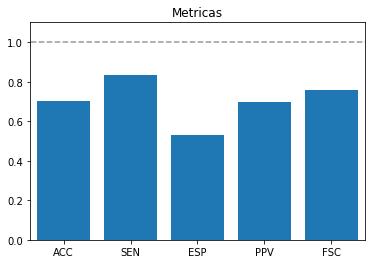

In [139]:
confmat = confusion_matrix(small_split['test'][1], predicciones_para_confmat)
metricas = calcula_metricas(confmat)

In [140]:
resultado = ['Boosted Tree - Lemma - Small Dataset', grid_search.best_params_, train_score, test_score,
             confmat, metricas]

add_row(resultadosModelo, resultado)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
0,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,"[[692, 614], [282, 1412]]","[0.7013333333333334, 0.833530106257379, 0.5298..."
1,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,"[[562, 744], [262, 1432]]","[0.6646666666666666, 0.8453364817001181, 0.430..."
2,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,"[[362, 944], [114, 1580]]","[0.6473333333333333, 0.9327036599763873, 0.277..."
3,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,"[[704, 602], [327, 1367]]","[0.6903333333333334, 0.806965761511216, 0.5390..."
4,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
5,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
6,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
7,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
8,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."


In [156]:
resultadosModelo.to_csv(RESULT_FILE)

### 1.1.6 Conclusiones

Resulta destacable que, aunque el modelo que mejor se comporta es el de SVM, uno de los mejores modelos es el más sencillo, un Bayes. 

**¿Qué puede indicar?**

Pues probalemente que al quitar datos el modelo que  podiamos generar se ha resentido. En la primera iteración, cuando trabajaba con el dataset completo, al usar Bayes he obtenido un `acc=0.77` mientras que con el dataset reducido ha sido de `0.72`.

Tambien es cierto que es posible que la selección de caracteristicas en el vectorizador (y en el stemming) no esté optimizada para el problema, y se pudiese trabajar más en ella. Por poner un ejemplo, se ve que en el dataset hay caracteres extraños, procedentes de un [error de decodificación de utf-8](https://www.i18nqa.com/debug/utf8-debug.html). Esos errores pueden enmascarar caracteres unicodes tipo emojis que pueden tambien ser interesantes en la interpretacion de sentimientos. No es lo mismo usar un 😊que 🙁, y cuando he hecho la vectorización he ignorado todos esos datos. 

En cualquier caso aqui tienes una tabla resumen de todos los experimentos.

In [160]:
resultadosModelo.sort_values(by=['test'], ascending=False)

,Modelo,parametros-optimos,train,test,confusion_matrix,acc_sen_esp_ppv_fsc
5,SVM - Small Dataset,"{'svm__C': 5.994842503189409, 'svm__gamma': 0....",0.716000,0.733000,[[ 799 507]\n [ 294 1400]],"[0.733, 0.8264462809917356, 0.611791730474732,..."
9,Boosted Tree - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.714857,0.728667,[[ 784 522]\n [ 292 1402]],"[0.7286666666666667, 0.8276269185360094, 0.600..."
6,Bayes - Small Dataset,"{'vect__analyzer': 'char', 'vect__max_df': 1.0...",0.717000,0.722333,[[ 909 397]\n [ 436 1258]],"[0.7223333333333334, 0.7426210153482881, 0.696..."
1,Boosted Tree - Lemma - Small Dataset,"{'boosted__learning_rate': 0.1, 'boosted__max_...",0.686955,0.701333,"[[692, 614], [282, 1412]]","[0.7013333333333334, 0.833530106257379, 0.5298..."
4,Bayes - Lemma - Small Dataset,"{'vect__analyzer': 'word', 'vect__max_df': 0.5...",0.686670,0.690333,"[[704, 602], [327, 1367]]","[0.6903333333333334, 0.806965761511216, 0.5390..."
0,SVM - Lemma - Small Dataset,"{'svm__C': 1.0, 'svm__gamma': 0.03162277660168...",0.665524,0.685000,"[[508, 798], [147, 1547]]","[0.685, 0.9132231404958677, 0.3889739663093415..."
8,Random Forestyes - Small Dataset,"{'forest__max_depth': 23, 'vect__analyzer': 'c...",0.668857,0.665000,[[ 630 676]\n [ 329 1365]],"[0.665, 0.8057851239669421, 0.4823889739663093..."
2,Random Forestyes - Lemma - Small Dataset,"{'forest__max_depth': 28, 'vect__analyzer': 'c...",0.660237,0.664667,"[[562, 744], [262, 1432]]","[0.6646666666666666, 0.8453364817001181, 0.430..."
7,Decision Tree - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.653286,0.649667,[[ 479 827]\n [ 224 1470]],"[0.6496666666666666, 0.8677685950413223, 0.366..."
3,Decision Tree - Lemma - Small Dataset,"{'tree__max_depth': 19, 'vect__analyzer': 'wor...",0.650236,0.647333,"[[362, 944], [114, 1580]]","[0.6473333333333333, 0.9327036599763873, 0.277..."


In [ ]:
resultadosModelo.to_csv(RESULT_FILE)